In [1]:
Pkg.add("Gadfly")
using Gadfly
using DataFrames

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Gadfly
INFO: Use `Pkg.update()` to get the latest versions of your packages


# Parameters

In [2]:
@enum DataSource concentriccircles=1 spiral=2

samples_per_class = 100; # number of data points per class
data_distortion = 0.02; # set to 0 for no distortion
data_source = spiral; # spiral or circle
num_classes = 3; # number of different classes

const num_dimensions = 2; # Number of dimensions (x, y), changing this will break all plotting

# computed values
N = samples_per_class * num_classes

# Generate our data sets

In [3]:
# generate data
function getCircle(dots, radius, x=0, y=0)
    angles = randn(dots).*(2*pi)
    xs = cos(angles).*radius.+x
    ys = sin(angles).*radius.+y
    return [ xs ys ]
end

function getSpiral(dots, degrees, rate=1.0)
    angles = linspace(pi/3, degrees, dots)
    radii = angles.*rate
    X = [ f(angles[i]) * radii[i] for i in 1:dots, f in [cos, sin]]
end

if data_source == concentriccircles
    Data = getCircle(samples_per_class, 1.5)
    Labels = ones(Int64, samples_per_class)
    for i in 2:num_classes
        Data = vcat(Data, getCircle(samples_per_class, i*1.5, 2, 2))
        Labels = vcat(Labels, ones(Int64, samples_per_class).*i)
    end
elseif data_source == spiral
    Data = getSpiral(samples_per_class, 2pi, 1.5)
    Labels = ones(Int64, samples_per_class)
    for i in 2:num_classes
        Data = vcat(Data, getSpiral(samples_per_class, 2pi, i*1.5))
        Labels = vcat(Labels, ones(Int64, samples_per_class).*i)
    end
end

In [4]:
# Visualization helper functions
function predictClasses(data, getScores)
    scores = getScores(data)
    exp_scores = e.^scores
    _, max_indices = findmax(exp_scores', 1)
    transpose((max_indices-1)%num_classes+1)
end

function output_learning_status_image(iteration, getScores)
    data = [ [x y] for x in linspace(-1, 1, 50), y in linspace(-1, 1, 50) ]
    data = vcat(data...)
    data = convert(DataFrame, [data predictClasses(data, getScores)])
    original_data = convert(DataFrame, [DistortedData Labels])
    p = plot(
        layer(original_data, x=:x1, y=:x2, color=:x3, Geom.point),
        layer(data, x=:x1, y=:x2, color=:x3, Geom.point),
        Guide.title("Iteration $(iteration)")
    )
    draw(SVGJS("./images/test_$(lpad(iteration,6,0)).js.svg", 6inch, 6inch), p)
end

function plot_data(df)
    plot(df, x=:x1, y=:x2, color=:x3, Geom.point)
end

plot_data (generic function with 1 method)

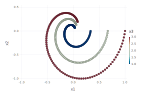

In [5]:
# Normalize the data so that it is between -1 and 1
NormalizedData = Data ./ repmat(maximum(abs(Data), 1), N) 
plot_data(convert(DataFrame, [NormalizedData Labels]))

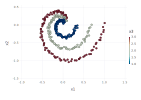

In [6]:
# Add some randomization to the dataset
DistortedData = NormalizedData + randn(N, num_dimensions).*data_distortion;
plot_data(convert(DataFrame, [DistortedData Labels]))

# Implement linear regression

In [7]:
# Basic linear regression implementation
function linear_regression(data, labels)
    
    # parameters
    step_size = 1e-1;
    iterations = 1000;
    regularization = 1e-3; # regularization strength
    
    # randomly initialize weights
    W = randn(num_dimensions, num_classes) .* 0.01

    # randomly initialize bias vector
    b = zeros(1, num_classes)
    
    # compute the gradient on normalized_scores (based on the derivative of the loss function)
    correct_class_bitmask = zeros(N, num_classes)
    for (index, label_idx) in enumerate(labels)
        correct_class_bitmask[index, Int64(label_idx)] = 1
    end

    # begine linear regression
    for iter in 1:iterations

        # compute scores
        scores = data * W + repmat(b, N)

        # compute normalized log probabilities (e^scores)
        exp_scores = exp(scores)

        # e^scores / ( sum(e^scores) )
        normalized_scores = exp_scores ./ repmat(sum(exp_scores, 2)', size(exp_scores, 2))'

        # normalized log-likelyhood -log(e^scores / ( sum(e^scores)))
        normalized_log_likelyhood = -log(normalized_scores[map(b -> b == 1 ,correct_class_bitmask)])
        total_error = sum(normalized_log_likelyhood)/N + 0.5*regularization*sum(W.*W)
        if iter < 10 || iter % 100 == 0
            println("ITER: $(iter), ERROR: $(total_error)")
            output_learning_status_image(iter, (d) -> d * W + repmat(b, size(d, 1)))
        end
        
        # log likelihood gradient
        dscores = normalized_scores - correct_class_bitmask
        dscores ./= N
        
        dW = data'*dscores + regularization.*W 
        db = sum(dscores, 1)
        
        W += -step_size .* dW
        b += -step_size * db
    end
    return W, b
end

In [9]:
linear_regression(DistortedData, Labels)

ITER: 1, ERROR: 1.0989493134632762
ITER: 2, ERROR: 1.0987771101171346
ITER: 3, ERROR: 1.0986068796397523
ITER: 4, ERROR: 1.0984385735996665
ITER: 5, ERROR: 1.098272146048011
ITER: 6, ERROR: 1.0981075533577822
ITER: 7, ERROR: 1.0979447540739322
ITER: 8, ERROR: 1.09778370877358
ITER: 9, ERROR: 1.0976243799356311
ITER: 100, ERROR: 1.0878864537405888
ITER: 200, ERROR: 1.0830719461506888
ITER: 300, ERROR: 1.0808466866772906
ITER: 400, ERROR: 1.079756144572546
ITER: 500, ERROR: 1.0791959882466438
ITER: 600, ERROR: 1.0788979155286273
ITER: 700, ERROR: 1.0787352139278565
ITER: 800, ERROR: 1.078644805342795
ITER: 900, ERROR: 1.078593945950078
ITER: 1000, ERROR: 1.0785650928067545


(
[0.18921 0.0208818 -0.214568; 0.68392 -0.0151383 -0.660259],

[0.108685 0.0155359 -0.124221])

In [10]:
function linear_regression_two_layers(data, labels)
    step_size = 1e-1
    iterations = 10000
    hidden_layer_size = 100
    regularization = 1e-3; # regularization strength
        
    # randomly initialize weights
    W = randn(num_dimensions, hidden_layer_size) .* 0.01
    W2 = randn(hidden_layer_size, num_classes).* 0.01
    
    # randomly initialize bias vector
    b = zeros(1, hidden_layer_size)
    b2 = zeros(1, num_classes)
    
    # compute the gradient on normalized_scores
    correct_class_bitmask = zeros(N, num_classes)
    for (index, label_idx) in enumerate(labels)
        correct_class_bitmask[index, Int64(label_idx)] = 1
    end

    # begine linear regression
    for iter in 1:iterations

        # compute scores (forward pass)
        hidden_layer = max(0, data * W + repmat(b, N))
        scores = hidden_layer * W2 + repmat(b2, N)

        # compute normalized log probabilities (e^scores)
        exp_scores = e.^scores

        # e^scores / ( sum(e^scores) )
        normalized_scores = exp_scores ./ repmat(sum(exp_scores, 2)', size(exp_scores, 2))'

        # normalized log-likelyhood -log(e^scores / ( sum(e^scores)))
        normalized_log_likelyhood = -log(normalized_scores[map(b -> b == 1, correct_class_bitmask)])
        total_error = sum(normalized_log_likelyhood)/N 
            + 0.5*regularization*sum(W.*W) 
            + 0.5*regularization*sum(W2.*W2)
        if (iter < 100 && iter % 10 == 0) || iter % 1000 == 0
            println("ITER: $(iter), ERROR: $(total_error)")
            output_learning_status_image(
                iter, 
                (d) -> max(0, d*W+repmat(b, size(d, 1)))*W2+repmat(b2, size(d, 1))
            )
        end
            
        # log likelihood gradient
        dscores = normalized_scores - correct_class_bitmask
        dscores ./= N
        
        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = hidden_layer'*dscores + regularization .* W2
        db2 = sum(dscores, 1)
        
        # next backprop into hidden layer
        dhidden = dscores*W2'
        
        # backprop the ReLU non-linearity
        dhidden[hidden_layer .<= 0] = 0

        # finally into W,b
        dW = data' * dhidden + regularization .* W
        db = sum(dhidden, 1)
        
        # update our parameters
        W += -step_size .* dW
        b += -step_size * db
        W2 += -step_size .* dW2
        b2 += -step_size * db2
    end
end

In [11]:
linear_regression_two_layers(DistortedData, Labels)

ITER: 10, ERROR: 1.098542791043839
ITER: 20, ERROR: 1.0984986371665502
ITER: 30, ERROR: 1.0984535210635238
ITER: 40, ERROR: 1.0984049083112732
ITER: 50, ERROR: 1.0983546951645533
ITER: 60, ERROR: 1.098302188626156
ITER: 70, ERROR: 1.0982458019436474
ITER: 80, ERROR: 1.098186153811588
ITER: 90, ERROR: 1.0981230498711412
ITER: 1000, ERROR: 0.9429392606078705
ITER: 2000, ERROR: 0.5117019588149965
ITER: 3000, ERROR: 0.303235175744771
ITER: 4000, ERROR: 0.22167533896043315
ITER: 5000, ERROR: 0.18424179568016227
ITER: 6000, ERROR: 0.16420146938232058
ITER: 7000, ERROR: 0.15210476468339182
ITER: 8000, ERROR: 0.1445430382618084
ITER: 9000, ERROR: 0.13927015941255227
ITER: 10000, ERROR: 0.135429082410818
